In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tqdm
import os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller,acf,pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pandas import Series

In [2]:
sales=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/sales_train.csv'))
shops=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/shops.csv'))
test=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/test.csv'))
item_cat=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/item_categories.csv'))
item=pd.read_csv(os.path.join(os.getcwd(),'data/competitive-data-science-predict-future-sales/items.csv'))

In [3]:
sales['date']=sales.date.apply(lambda x: pd.to_datetime(x))
monthly_sales=sales.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'date':['min','max'],'item_price':'mean','item_cnt_day':'sum'})

Text(0.5, 1.0, 'Top10 Item Cat by Count')

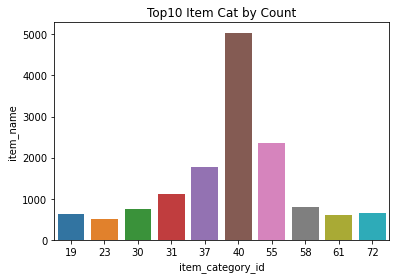

In [26]:
top10_items=item.groupby(['item_category_id']).count().sort_values(by=['item_name'],ascending=False).iloc[:10]
sns.barplot(top10_items.index,top10_items.item_name).set_title('Top10 Item Cat by Count')

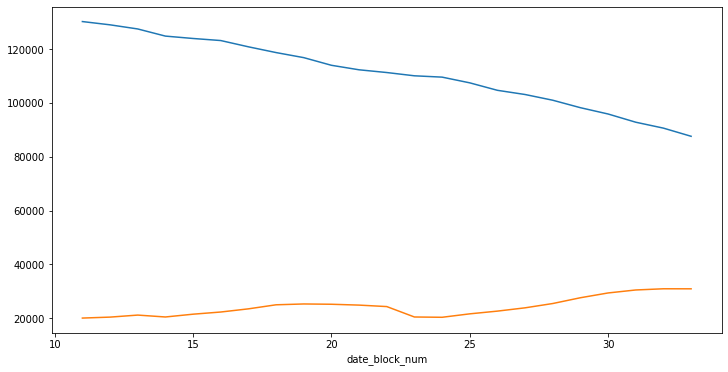

In [3]:
## Mean of accumulated sum to identify trends
ts=sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(12,6))
ts.rolling(window=12,center=False).mean().plot()
ts.rolling(window=12,center=False).std().plot()

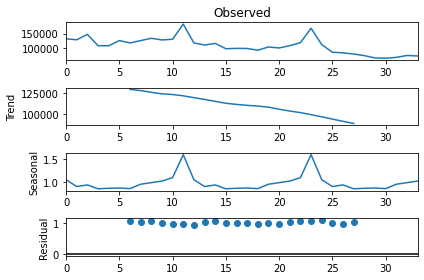

In [87]:
# 'multiplicative model'
sm.tsa.seasonal_decompose(ts.values,freq=12,model='multiplicative').plot()
plt.show()

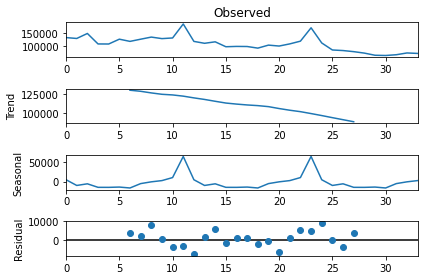

In [90]:
# 'Additive model'
sm.tsa.seasonal_decompose(ts.values,freq=12,model='additive').plot()
plt.show()

In [49]:
## Stationarity tests
def test_stationarity(ts):
    print('Results of Dickey-Fuller Test:')
    dtest=adfuller(ts,autolag='AIC')
    dfoutput=pd.Series(dtest[:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dtest[4].items():
        dfoutput['Critical Value {}'.format(key)]=value
    print(dfoutput)

In [50]:
## P_value >5%
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value 1%              -3.646135
Critical Value 5%              -2.954127
Critical Value 10%             -2.615968
dtype: float64


In [126]:
def difference(df,interval=1):
    diff=[]
    for i in range(interval,len(df)):
        value=df[i]-df[i-interval]
        diff.append(value)
    return pd.Series(diff)
def inverse_diff(last_ob,value):
    return value+last_ob

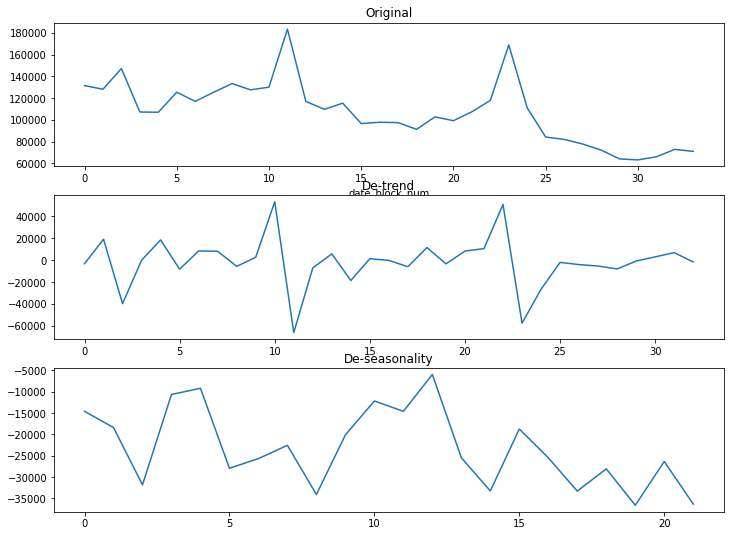

In [60]:
new_ts=difference(ts)
new_12_ts=difference(ts,12)
plt.figure(figsize=(12,9))
plt.subplot(311)
ts.plot(title='Original')
plt.subplot(312)
new_ts.plot(title='De-trend')
plt.subplot(313)
new_12_ts.plot(title='De-seasonality')

In [61]:
## p-value <5% now stationarity of the ts
test_stationarity(new_12_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value 1%              -3.788386
Critical Value 5%              -3.013098
Critical Value 10%             -2.646397
dtype: float64


## AR,MA and ARMA Models

In [77]:
def tsplot(y,lags=None,figsize=(10,8),style='bmh',title=''):
    if not isinstance(y,pd.Series):
        y=pd.Series(y)
    with plt.style.context(style):
        fig=plt.figure(figsize=figsize)
        layout=(3,2)
        ts_ax=plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax=plt.subplot2grid(layout,(1,0))
        pacf_ax=plt.subplot2grid(layout,(1,1))
        qq_ax=plt.subplot2grid(layout,(2,0))
        pp_ax=plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax,alpha=0.5)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax,alpha=0.5)
        sm.qqplot(y,line='s',ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y,sparams=(y.mean(),y.std()),plot=pp_ax)
        
        plt.tight_layout()
    return 

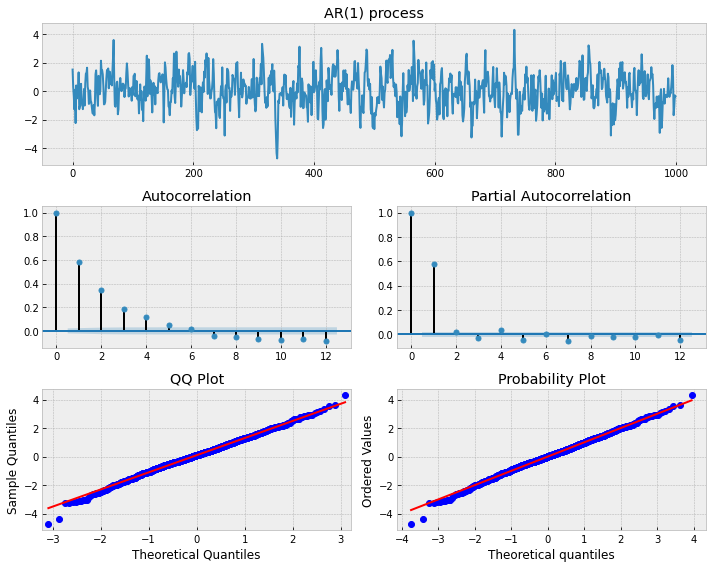

In [85]:
np.random.seed(1)
n_sampels=1000
a=0.6
x=w=np.random.normal(size=1000)
for t in range(n_sampels):
    x[t]=a*x[t-1]+w[t]
limit=12
_=tsplot(x,lags=limit,title='AR(1) process')

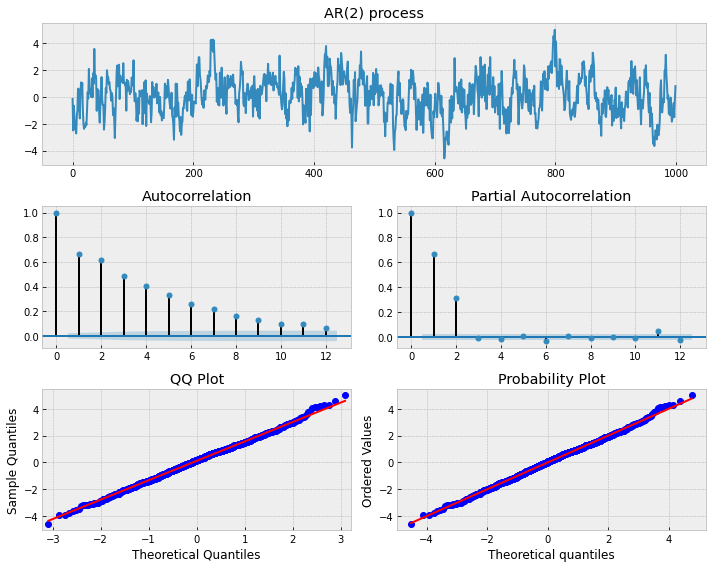

In [100]:
n=1000
alphas=np.array([.444,.333])
betas=np.array([0.])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]
ar2=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ar2,lags=12,title='AR(2) process')

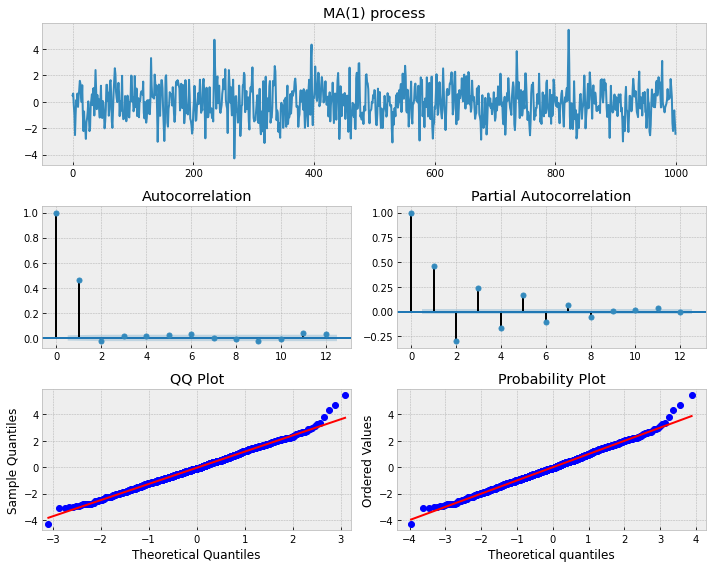

In [101]:
n=1000
alphas=np.array([0.])
betas=np.array([0.8])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]
ma1=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ma1,lags=12,title='MA(1) process')

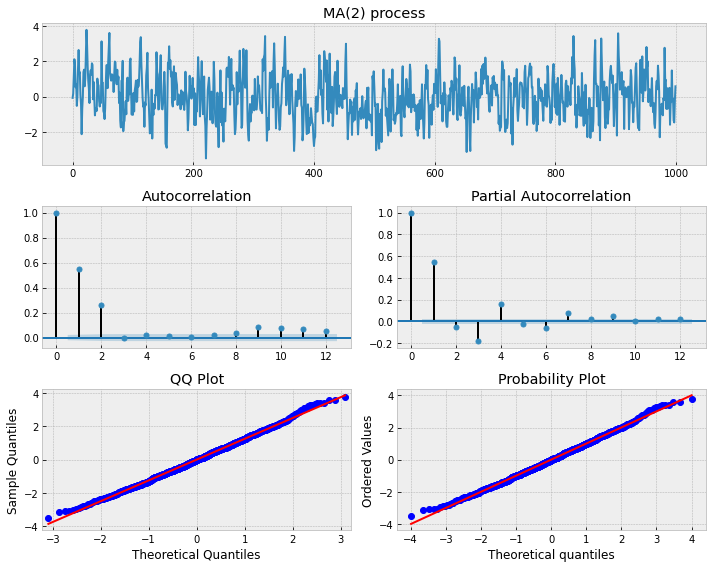

In [102]:
n=1000
alpahs=np.array([0.])
betas=np.array([0.6,0.4])
ar=np.r_[1,-alpahs]
ma=np.r_[1,betas]
ma2=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ma2,lags=12,title='MA(2) process')

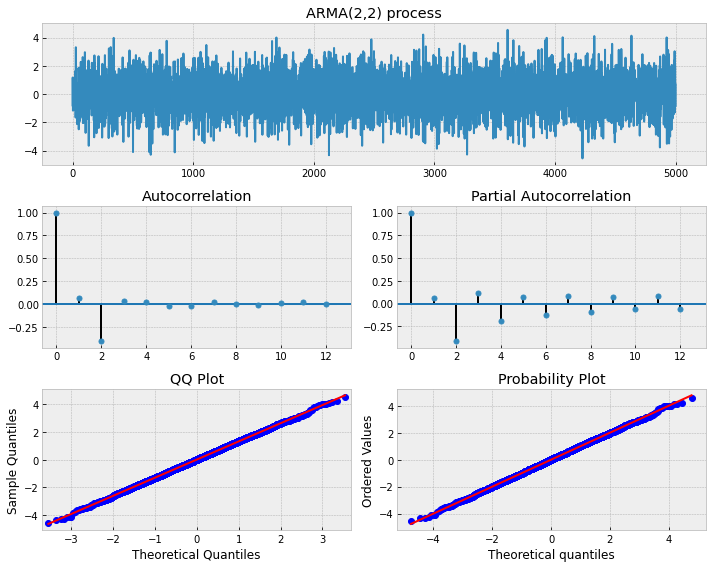

In [104]:
n=5000
burn=int(n/10)
alphas=np.array([0.8,-0.65])
betas=np.array([0.5,-0.7])
ar=np.r_[1,-alpahs]
ma=np.r_[1,betas]
arma=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n,burnin=burn)
_=tsplot(arma,lags=12,title='ARMA(2,2) process')

In [113]:
## Best Model: ARMA(1,1)
best_aic=np.inf
best_order=None
best_mdl=None
for i in range(5):
    for j in range(5):
        try:
            tmp_mdl=smt.ARMA(new_12_ts.values,order=(i,j)).fit(method='mle',trend='nc')
            tmp_aic=tmp_mdl.aic
            if tmp_aic<best_aic:
                best_aic=tmp_aic
                best_order=(i,j)
                best_mdl=tmp_mdl
        except:
            continue
print('aic:{} |order:{}'.format(best_aic,best_order))

aic:472.9970259779833 |order:(1, 1)


In [121]:
## Insert date index
ts.index=pd.date_range(start='2013-01-01',end='2015-10-01',freq='MS')
ts=ts.reset_index()